In [246]:
from valurap2 import path_planning, gcode

input_fn = "diplo.gcode"
seg_no = 6 #18

#input_fn = "box20.gcode"
#seg_no = 18

lines = gcode.reader(input_fn)
pg = gcode.path_gen(lines)
sg = gcode.gen_segments(pg)
for i, s in enumerate(sg):
    if isinstance(s, gcode.do_segment):
        print("segment", i, len(s.path))
        
    if i == seg_no:
        break
        
print(s.path)

Extruder switch to 0
do_extruder
Do Home
do_home
Set current ['E0']
Set current ['E0']
Set current ['E0']
Set current ['E0']
segment 6 663
[[43.557, -1.568000000000012, 0, -3.0, 32], [43.8, 1.249999999999988, 75.0, -3.14111, 33], [44.121, 4.036999999999988, 75.0, -3.2810799999999998, 34], [44.521, 6.825999999999988, 75.0, -3.42164, 35], [45.0, 9.60199999999999, 75.0, -3.56218, 36], [45.558, 12.36499999999999, 75.0, -3.7028100000000004, 37], [45.975, 14.202999999999989, 75.0, -3.7968400000000004, 38], [46.045, 14.49699999999999, 75.0, -3.8119200000000006, 39], [46.39, 16.10099999999999, 75.0, -3.893770000000001, 40], [46.542, 16.954999999999988, 75.0, -3.937050000000001, 41], [46.678, 17.867999999999988, 75.0, -3.983100000000001, 42], [46.77, 18.54499999999999, 75.0, -4.017190000000001, 43], [46.903, 19.69999999999999, 75.0, -4.075190000000001, 44], [46.949, 20.210999999999988, 75.0, -4.100790000000001, 45], [47.02, 21.027999999999988, 75.0, -4.141700000000001, 46], [47.088, 21.97799999

In [247]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import collections  as mc

%matplotlib notebook


path = np.array(s.path)

df = pd.DataFrame({"x": path[:, 0], "y": path[:, 1], "v": path[:,2]})
df["dx"] = df["x"] - df["x"].shift(1)
df["dy"] = df["y"] - df["y"].shift(1)
df["next_dx"] = df["dx"].shift(-1)
df["next_dy"] = df["dy"].shift(-1)
df["d"] = np.linalg.norm([df["dx"], df["dy"]], axis=0)
df["dt"] = df["d"] / df["v"]

if 0:
    def add_angle(df):
        df["angle"] = 180 - np.arccos((df["dx"]*df["next_dx"] + df["dy"]*df["next_dy"])/np.linalg.norm([df["dx"], df["dy"]], axis=0)/np.linalg.norm([df["next_dx"], df["next_dy"]], axis=0)) * 180 / math.pi

    def add_circle(df):
        x1 = df["x"].shift(1)
        y1 = df["y"].shift(1)
        x2 = df["x"]
        y2 = df["y"]
        x3 = df["x"].shift(-1)
        y3 = df["y"].shift(-1)

        x12 = x1 - x2;  
        x13 = x1 - x3;  

        y12 = y1 - y2;  
        y13 = y1 - y3;  

        y31 = y3 - y1;  
        y21 = y2 - y1;  

        x31 = x3 - x1;  
        x21 = x2 - x1;  

        sx13 = x1 * x1 - x3 * x3 
        sy13 = y1 * y1 - y3 * y3  

        sx21 = x2 * x2 - x1 * x1;  
        sy21 = y2 * y2 - y1 * y1;  

        f = (sx13 * x12 + sy13 * x12 + sx21 * x13 + sy21 * x13) / (2 * (y31 * x12 - y21 * x13))              
        g = (sx13 * y12 + sy13 * y12 + sx21 * y13 + sy21 * y13) / (2 * (x31 * y12 - x21 * y13))
        c = -x1 * x1 - y1 * y1 - 2 * g * x1 - 2 * f * y1

        cx = -g 
        cy = -f

        r = np.sqrt(cx * cx + cy * cy - c)

        v1x = x1 - cx
        v2x = x2 - cx
        v3x = x3 - cx

        v1y = y1 - cy
        v2y = y2 - cy
        v3y = y3 - cy

        v12x = (v1x + v2x) / 2
        v12y = (v1y + v2y) / 2
        d12 = r - np.linalg.norm([v12x, v12y], axis=0)
        p12x = cx + v12x / (r - d12) * r
        p12y = cy + v12y / (r - d12) * r

        v23x = (v2x + v3x) / 2
        v23y = (v2y + v3y) / 2
        d23 = r - np.linalg.norm([v23x, v23y], axis=0)
        p23x = cx + v23x / (r - d23) * r
        p23y = cy + v23y / (r - d23) * r

        df["r"] = r
        df["cx"] = cx
        df["cy"] = cy
        df["d12"] = d12
        df["d23"] = d23
        df["p12x"] = p12x
        df["p12y"] = p12y
        df["p23x"] = p23x
        df["p23y"] = p23y

    add_angle(df)
    add_circle(df)

    sdf = df[20:-20]
    lines = []
    colors = []
    for l in sdf.iterrows():
        l = l[1]
        lines.append(((l.x, l.y),(l.cx, l.cy)))
        colors.append([0,1,0])
        lines.append(((l.cx, l.cy),(l.p12x, l.p12y)))
        colors.append([1,0,0])
        lines.append(((l.cx, l.cy),(l.p23x, l.p23y)))
        colors.append([1,1,0])

    lc = mc.LineCollection(lines, colors=colors, linewidths=1)

    display(sdf)
    ax = sdf.plot(x="x", y="y", style=".-")
    ax.add_collection(lc)


    plt.axis("square")


    #display(p.ax)

In [248]:
pp = path_planning.PathPlanner()
path = s.path
path, slowdowns = pp.make_path(path)
slowdowns, updated, cc = pp.process_corner_errors(path, slowdowns)
slowdowns, updated = pp.reverse_pass(path, slowdowns)
slowdowns, updated = pp.forward_pass(path, slowdowns)
_, updated = pp.forward_pass(path, slowdowns)

assert updated == 0

speeds = pp.gen_speeds(path, slowdowns)
_, _, cc = pp.process_corner_errors(path, slowdowns)

plato = pd.DataFrame()
plato["middle_x"] = path["px"] + cc["mdx"]
plato["middle_y"] = path["py"] + cc["mdy"]
plato["middle_e"] = path["pe"]
plato["middle_vx"] = cc["mvx"]
plato["middle_vy"] = cc["mvy"]
plato["middle_v"] = np.linalg.norm(cc[["mvx", "mvy"]], axis=1)

plato["start_x"] = path["px"] + speeds["unit_x"] * cc["l_entry"]
plato["start_y"] = path["py"] + speeds["unit_y"] * cc["l_entry"]
plato["start_e"] = path["pe"] + speeds["unit_e"] * cc["l_entry"]
plato["start_vx"] = speeds["entry_x"]
plato["start_vy"] = speeds["entry_y"]
plato["start_v"] = speeds["entry"]
plato["top_vx"] = speeds["plato_x"]
plato["top_vy"] = speeds["plato_y"]
plato["top_v"] = speeds["plato"]
plato["end_x"] = path["x"] - speeds["unit_x"] * cc["l_exit"]
plato["end_y"] = path["y"] - speeds["unit_y"] * cc["l_exit"]
plato["end_e"] = path["e"] - speeds["unit_e"] * cc["l_exit"]
plato["end_vx"] = speeds["exit_x"]
plato["end_vy"] = speeds["exit_y"]
plato["end_v"] = speeds["exit"]
plato["v_to_ve"] = speeds["v_to_ve"]

plato["pre_x"] = plato["end_x"].shift(1).fillna(path["px"][0])
plato["pre_y"] = plato["end_y"].shift(1).fillna(path["py"][0])
plato["pre_e"] = plato["end_e"].shift(1).fillna(0)
plato["pre_vx"] = plato["end_vx"].shift(1).fillna(0)
plato["pre_vy"] = plato["end_vy"].shift(1).fillna(0)
plato["pre_v"] = plato["end_v"].shift(1).fillna(0)
plato["pre_v_to_ve"] = plato["v_to_ve"].shift(1).fillna(0)
plato["corner_dt"] = cc["dt"]

plato["plato_l"] = cc["l_free"]
plato["max_top_v"] = np.sqrt(2 * speeds["max_a"] * 0.9 * plato["plato_l"] + pow(plato["start_v"], 2) + pow(plato["end_v"], 2)) / np.sqrt(2)

assert all(plato["max_top_v"] >= plato["start_v"])
assert all(plato["max_top_v"] >= plato["end_v"])

plato["real_top_v"] = np.min(plato[["top_v", "max_top_v"]], axis=1)
plato["real_top_vx"] = plato["real_top_v"] * speeds["unit_x"]
plato["real_top_vy"] = plato["real_top_v"] * speeds["unit_y"]
plato["accel_dt"] = (plato["real_top_v"] - plato["start_v"]) / speeds["max_a"]
plato["decel_dt"] = (plato["real_top_v"] - plato["end_v"]) / speeds["max_a"]
plato["accel_l"] = (plato["real_top_v"] + plato["start_v"]) * plato["accel_dt"] / 2
plato["decel_l"] = (plato["real_top_v"] + plato["end_v"]) * plato["decel_dt"] / 2
plato["top_l"] = plato["plato_l"] - plato["accel_l"] - plato["decel_l"]
plato["top_dt"] = (plato["top_l"] / plato["real_top_v"]).fillna(0)
plato["dt"] = plato["corner_dt"] + plato["accel_dt"] + plato["top_dt"] + plato["decel_dt"]
plato["t"] = np.cumsum(plato["dt"]).shift(1).fillna(0)
#display(plato)
#display(plato.iloc[0])
#display(plato.iloc[1])
#display(plato.iloc[-2])
#display(plato.iloc[-1])

pre_corner_segs = pd.DataFrame()
pre_corner_segs["idx"] = plato.index.values * 5
pre_corner_segs["tp"] = 0
pre_corner_segs["line"] = path["line"]
pre_corner_segs["t"] = plato["t"]

dt = plato["corner_dt"] / 2
dt[0] = 0
dt[len(dt) - 1] *= 2 
pre_corner_segs["dt"] = dt

pre_corner_segs["start_x"] = plato["pre_x"]
pre_corner_segs["start_y"] = plato["pre_y"]
pre_corner_segs["start_e"] = plato["pre_e"]
pre_corner_segs["start_vx"] = plato["pre_vx"]
pre_corner_segs["start_vy"] = plato["pre_vy"]
pre_corner_segs["end_x"] = plato["middle_x"]
pre_corner_segs["end_y"] = plato["middle_y"]
pre_corner_segs["end_e"] = plato["middle_e"]
pre_corner_segs["end_vx"] = plato["middle_vx"]
pre_corner_segs["end_vy"] = plato["middle_vy"]
pre_corner_segs["v_to_ve"] = plato["pre_v_to_ve"]

corner_segs = pd.DataFrame()
corner_segs["idx"] = pre_corner_segs["idx"] + 1
corner_segs["tp"] = 1
corner_segs["line"] = path["line"]
corner_segs["t"] = pre_corner_segs["t"] + pre_corner_segs["dt"]

dt = plato["corner_dt"] / 2
dt[0] *= 2
dt[len(dt) - 1] = 0 
corner_segs["dt"] = dt

corner_segs["start_x"] = pre_corner_segs["end_x"]
corner_segs["start_y"] = pre_corner_segs["end_y"]
corner_segs["start_e"] = pre_corner_segs["end_e"]
corner_segs["start_vx"] = pre_corner_segs["end_vx"]
corner_segs["start_vy"] = pre_corner_segs["end_vy"]
corner_segs["end_x"] = plato["start_x"]
corner_segs["end_y"] = plato["start_y"]
corner_segs["end_e"] = plato["start_e"]
corner_segs["end_vx"] = plato["start_vx"]
corner_segs["end_vy"] = plato["start_vy"]
corner_segs["v_to_ve"] = plato["v_to_ve"]

accel_segs = pd.DataFrame()
accel_segs["idx"] = corner_segs["idx"] + 1
accel_segs["tp"] = 2
accel_segs["line"] = path["line"]
accel_segs["t"] = corner_segs["t"] + corner_segs["dt"]
accel_segs["dt"] = plato["accel_dt"]
accel_segs["start_x"] = corner_segs["end_x"]
accel_segs["start_y"] = corner_segs["end_y"]
accel_segs["start_e"] = corner_segs["end_e"]
accel_segs["start_vx"] = corner_segs["end_vx"]
accel_segs["start_vy"] = corner_segs["end_vy"]
accel_segs["end_x"] = accel_segs["start_x"] + speeds["unit_x"] * plato["accel_l"]
accel_segs["end_y"] = accel_segs["start_y"] + speeds["unit_y"] * plato["accel_l"]
accel_segs["end_e"] = accel_segs["start_e"] + speeds["unit_e"] * plato["accel_l"]
accel_segs["end_vx"] = plato["real_top_vx"]
accel_segs["end_vy"] = plato["real_top_vy"]
accel_segs["v_to_ve"] = plato["v_to_ve"]

top_segs = pd.DataFrame()
top_segs["idx"] = accel_segs["idx"] + 1
top_segs["tp"] = 3
top_segs["line"] = path["line"]
top_segs["t"] = accel_segs["t"] + accel_segs["dt"]
top_segs["dt"] = plato["top_dt"]
top_segs["start_x"] = accel_segs["end_x"]
top_segs["start_y"] = accel_segs["end_y"]
top_segs["start_e"] = accel_segs["end_e"]
top_segs["start_vx"] = accel_segs["end_vx"]
top_segs["start_vy"] = accel_segs["end_vy"]
top_segs["end_x"] = top_segs["start_x"] + speeds["unit_x"] * plato["top_l"]
top_segs["end_y"] = top_segs["start_y"] + speeds["unit_y"] * plato["top_l"]
top_segs["end_e"] = top_segs["start_e"] + speeds["unit_e"] * plato["top_l"]
top_segs["end_vx"] = top_segs["start_vx"]
top_segs["end_vy"] = top_segs["start_vy"]
top_segs["v_to_ve"] = plato["v_to_ve"]

decel_segs = pd.DataFrame()
decel_segs["idx"] = top_segs["idx"] + 1
decel_segs["tp"] = 4
decel_segs["line"] = path["line"]
decel_segs["t"] = top_segs["t"] + top_segs["dt"]
decel_segs["dt"] = plato["decel_dt"]
decel_segs["start_x"] = top_segs["end_x"]
decel_segs["start_y"] = top_segs["end_y"]
decel_segs["start_e"] = top_segs["end_e"]
decel_segs["start_vx"] = top_segs["end_vx"]
decel_segs["start_vy"] = top_segs["end_vy"]
decel_segs["end_x"] = plato["end_x"]
decel_segs["end_y"] = plato["end_y"]
decel_segs["end_e"] = plato["end_e"]
decel_segs["end_vx"] = plato["end_vx"]
decel_segs["end_vy"] = plato["end_vy"]
decel_segs["v_to_ve"] = plato["v_to_ve"]

pre_corner_segs = pre_corner_segs.set_index("idx")
corner_segs = corner_segs.set_index("idx")
accel_segs = accel_segs.set_index("idx")
top_segs = top_segs.set_index("idx")
decel_segs = decel_segs.set_index("idx")

all_segs_raw = pd.concat([pre_corner_segs, corner_segs, accel_segs, top_segs, decel_segs]).sort_index()
all_segs_filter = (all_segs_raw["dt"] > 1e-5).values
all_segs_filter[0] = True
all_segs_filter[-1] = True
all_segs = all_segs_raw[all_segs_filter][[
    "tp", "line", "t", "v_to_ve", "start_x", "start_y", "start_e", "start_vx", "start_vy",
]].copy().sort_index()

all_segs["start_v"] = np.linalg.norm(all_segs[["start_vx", "start_vy"]], axis = 1)
all_segs["end_x"] = all_segs["start_x"].shift(-1)
all_segs["end_y"] = all_segs["start_y"].shift(-1)
all_segs["end_e"] = all_segs["start_e"].shift(-1)
all_segs["end_vx"] = all_segs["start_vx"].shift(-1)
all_segs["end_vy"] = all_segs["start_vy"].shift(-1)
all_segs["end_v"] = all_segs["start_v"].shift(-1)
all_segs["dt"] = all_segs["t"].shift(-1) - all_segs["t"]

all_segs = all_segs.iloc[1:-1,:]

all_segs["avg_v"] = (all_segs["start_v"] + all_segs["end_v"]) / 2

de = all_segs["end_e"] - all_segs["start_e"]
de[np.abs(de) < 1e-5] = 0
avg_ve = de / all_segs["dt"]

all_segs["dx"] = np.abs(80 * (all_segs["end_x"] - all_segs["start_x"]))
all_segs["dy"] = np.abs(80 * (all_segs["end_y"] - all_segs["start_y"]))
all_segs["de"] = np.abs(837 * de)
all_segs["dx_dt"] = all_segs["dt"] / all_segs["dx"] * 1000000
all_segs["dy_dt"] = all_segs["dt"] / all_segs["dy"] * 1000000
all_segs["de_dt"] = all_segs["dt"] / all_segs["de"] * 1000000
all_segs["avg_ve"] = avg_ve
all_segs["v_to_ve2"] = (all_segs["avg_ve"] / all_segs["avg_v"]).fillna(0)

all_segs                                  
            

cc updated 80
rp updated: 93
fp updated: 78


,tp,line,t,v_to_ve,start_x,start_y,start_e,start_vx,start_vy,start_v,...,dt,avg_v,dx,dy,de,dx_dt,dy_dt,de_dt,avg_ve,v_to_ve2
idx,,,,,,,,,,,,,,,,,,,,,
1,1,33,0.000000,-0.049889,43.557000,-1.568000,0.000000,0.000000,0.000000,0.000000,...,0.050488,25.337483,8.792145,101.959931,53.417285,5742.353881,495.171041,945.154842,-1.264071,-0.049889
2,2,33,0.050488,-0.049889,43.666902,-0.293501,-0.063820,4.353615,50.487605,50.674967,...,0.020098,60.761217,8.393132,97.332702,50.993058,2394.566852,206.486780,394.130439,-3.031339,-0.049889
3,3,33,0.070586,-0.049889,43.771816,0.923158,-0.124744,6.086686,70.585521,70.847467,...,0.002090,70.847467,1.017806,11.803198,6.183751,2053.662635,177.090142,338.019778,-3.534536,-0.049889
4,4,33,0.072676,-0.049889,43.784539,1.070698,-0.132132,6.086686,70.585521,70.847467,...,0.001593,70.047814,0.767121,8.896083,4.660700,2077.106876,179.111771,341.878551,-3.494642,-0.049889
5,0,34,0.074269,-0.049889,43.794128,1.181899,-0.137700,5.949286,68.992128,69.248161,...,0.000987,69.244607,0.508769,5.444162,2.854278,1940.141803,181.310679,345.826443,-3.454748,-0.049892
6,1,34,0.075256,-0.049893,43.800487,1.249951,-0.141110,6.936370,68.892745,69.241054,...,0.000987,69.244607,0.586716,5.436314,2.854463,1682.388547,181.572423,345.804003,-3.454972,-0.049895
7,2,34,0.076243,-0.049893,43.807821,1.317905,-0.144520,7.923455,68.793362,69.248161,...,0.005714,72.124080,3.772434,32.753190,17.210246,1514.688649,174.458219,332.015202,-3.598459,-0.049893
8,3,34,0.081957,-0.049893,43.854977,1.727320,-0.165082,8.581587,74.507425,75.000000,...,0.029966,75.000000,20.572692,178.617108,93.854807,1456.607010,167.768515,319.283882,-3.741946,-0.049893
10,0,35,0.111924,-0.049893,44.112135,3.960034,-0.277215,8.581587,74.507425,75.000000,...,0.001033,74.996383,0.751868,6.151794,3.235375,1373.914942,167.918996,319.283882,-3.741946,-0.049895


In [249]:
if 0:
    all_segs.plot(x="t", y=["avg_v", "v_to_ve", "v_to_ve2"], secondary_y=["v_to_ve", "v_to_ve2"])

In [250]:
if 0:
    all_segs.plot(x="start_x", y="start_y", style=".-")
    plt.axis("square")



In [251]:
track_t = []
track_x = []
track_y = []
track_e = []
track_e_exp = []
track_vx = []
track_vy = []
track_ve = []

last_e = 0
last_ve = 0
borders = 100

delta_t = 0.001

# first and last segments require patching, as j-only move takes 1.5x time
dt_first = all_segs["dt"].iloc[0]
extra_start = int(ceil(dt_first / delta_t)) + borders
last_t = -extra_start * delta_t

t_last = all_segs["t"].iloc[-1]
dt_last = all_segs["dt"].iloc[-1]
extra_end = int(ceil(dt_last / delta_t)) + borders
final_t = t_last + extra_end * delta_t

last_i = len(all_segs) - 1

for i, seg in enumerate(all_segs.itertuples()):
    t = seg.t
    dt = seg.dt
    end_t = t + dt

    st_x = seg.start_x
    st_vx = seg.start_vx
    tg_x = seg.end_x
    tg_vx = seg.end_vx

    dvx = tg_vx - st_vx
    ax = dvx / dt
    jx = 0

    st_y = seg.start_y
    st_vy = seg.start_vy
    tg_y = seg.end_y
    tg_vy = seg.end_vy

    dvy = tg_vy - st_vy
    ay = dvy / dt
    jy = 0
    
    st_e = seg.start_e
    tg_e = seg.end_e

    st_v = math.sqrt(st_vx * st_vx + st_vy * st_vy)
    tg_v = math.sqrt(tg_vx * tg_vx + tg_vy * tg_vy)
    st_ve = st_v * seg.v_to_ve
    tg_ve = tg_v * seg.v_to_ve

    if seg.tp in (0, 1):
        st_ve = tg_ve = (tg_e - st_e) / dt

    dve = tg_ve - st_ve
    ae = dve / dt
    je = 0

    calc_j = False
    if i == 0:
        dt *= 1.5
        t = end_t - dt
        
        tg_ve += st_ve
        st_ve = 0
        calc_j = True
    elif i == last_i:
        dt *= 1.5
        end_t = t + dt
        
        st_ve += tg_ve
        tg_ve = 0
        calc_j = True

    if calc_j:
        dx = tg_x - st_x
        dy = tg_y - st_y
        de = tg_e - st_e
        
        jx = -(12 * dx - 6 * dt * tg_vx - 6 * dt * st_vx) / dt / dt / dt
        ax = (6 * dx - 2 * dt * tg_vx - 4 * dt * st_vx) / dt / dt

        jy = -(12 * dy - 6 * dt * tg_vy - 6 * dt * st_vy) / dt / dt / dt
        ay = (6 * dy - 2 * dt * tg_vy - 4 * dt * st_vy) / dt / dt

        je = -(12 * de - 6 * dt * tg_ve - 6 * dt * st_ve) / dt / dt / dt
        ae = (6 * de - 2 * dt * tg_ve - 4 * dt * st_ve) / dt / dt
        
        print(ax, jx, ay, jy, ae, je)
                
    dx = st_vx * dt + ax * dt * dt / 2 + jx * dt * dt * dt / 6
    dx_err =  dx - (tg_x - st_x)

    dy = st_vy * dt + ay * dt * dt / 2 + jy * dt * dt * dt / 6
    dy_err =  dy - (tg_y - st_y)

    de = st_ve * dt + ae * dt * dt / 2 + je * dt * dt * dt / 6
    de_err =  de - (tg_e - st_e)

    try:
        assert abs(dx_err) < 1e-10
        assert abs(dy_err) < 1e-10
        assert abs(de_err) < 1e-10
    except:
        print(t, seg.tp, seg.line, dx_err, dy_err, de_err)
        raise
        
    if i == 0:
        while last_t < t:
            track_t.append(last_t)
            track_x.append(st_x)
            track_y.append(st_y)
            track_vx.append(st_vx)
            track_vy.append(st_vy)
            track_e.append(st_e)
            track_ve.append(st_ve)

            last_t += delta_t

    while last_t < end_t:
        ct = last_t - t
        dx = st_vx * ct + ax * ct * ct / 2 + jx * ct * ct * ct / 6
        dy = st_vy * ct + ay * ct * ct / 2 + jy * ct * ct * ct / 6
        de = st_ve * ct + ae * ct * ct / 2 + je * ct * ct * ct / 6
        x = st_x + dx
        y = st_y + dy
        e = st_e + de
        vx = st_vx + ax * ct + jx * ct * ct / 2
        vy = st_vy + ay * ct + jy * ct * ct / 2
        ve = st_ve + ae * ct + je * ct * ct / 2
        
        track_t.append(last_t)
        track_x.append(x)
        track_y.append(y)
        track_vx.append(vx)
        track_vy.append(vy)
        track_e.append(e)
        track_ve.append(ve)
        
        last_t += delta_t
        
while last_t < final_t:
    track_t.append(last_t)
    track_x.append(tg_x)
    track_y.append(tg_y)
    track_e.append(tg_e)
    track_vx.append(tg_vx)
    track_vy.append(tg_vy)
    track_ve.append(tg_ve)
    last_t += delta_t

df = pd.DataFrame()
df["t"] = track_t
df["x"] = track_x
df["y"] = track_y
df["e"] = track_e
df["vx"] = track_vx
df["vy"] = track_vy
df["ve"] = track_ve
df["v"] = np.linalg.norm(df[["vx", "vy"]], axis=1)
df["dx"] = (df["x"] - df["x"].shift(1)) * 80
df["dy"] = (df["y"] - df["y"].shift(1)) * 80
df["d"] = np.linalg.norm(df[["dx", "dy"]], axis=1)
df["de"] = - (df["e"] - df["e"].shift(1)) * 837

if 1:
    display(df)


3.5037793188549555e-12 1518.1965197285451 0.0 17606.08145100983 -9.678948394626948e-15 -881.6160942342065
-64.67661691541834 878.2515918065736 -1333.333333333333 18105.494354168193 66.5970149253784 -904.3289083019135


,t,x,y,e,vx,vy,ve,v,dx,dy,d,de
0,-0.151,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,-0.150,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2,-0.149,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
3,-0.148,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
4,-0.147,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
5,-0.146,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
6,-0.145,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
7,-0.144,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
8,-0.143,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
9,-0.142,43.557,-1.568,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


In [252]:
if 0:
    df.plot(x="x", y="y", style=".-")
    plt.axis("square")

In [253]:
df["de_smooth"] = - df["de"].rolling(20, center=True, win_type="hamming").mean() / 837
df["e_smooth"] = df["de_smooth"].cumsum()

df["de_adv"] = df["de_smooth"] * 5

df["e_adv"] = df["e_smooth"] + df["de_adv"]
df["e_sm_d"] = - (df["e_smooth"] - df["e_smooth"].shift(1)) * 837
df["e_adv_d"] = - (df["e_adv"] - df["e_adv"].shift(1)) * 837

if 0:
    df.plot(x="t", y=["de", "e_sm_d", "e_adv_d", "e", "e_adv"], secondary_y=["e", "e_adv"], style=".-")

In [254]:
df["dx_smooth"] = df["dx"].rolling(5, center=True, win_type="hamming").mean() / 80
df["dy_smooth"] = df["dy"].rolling(5, center=True, win_type="hamming").mean() / 80
df["x_smooth"] = df["dx_smooth"].cumsum() + df["x"].iloc[0]
df["y_smooth"] = df["dy_smooth"].cumsum() + df["y"].iloc[0]

if 0:
    df["x_smooth_d"] = (df["x_smooth"] - df["x_smooth"].shift(1)) * 80
    df["y_smooth_d"] = (df["y_smooth"] - df["y_smooth"].shift(1)) * 80
    df["x_smooth_dd"] = df["x_smooth_d"] - df["x_smooth_d"].shift(1)
    df["y_smooth_dd"] = df["y_smooth_d"] - df["y_smooth_d"].shift(1)
    df["x_smooth_ddd"] = df["x_smooth_dd"] - df["x_smooth_dd"].shift(1)
    df["y_smooth_ddd"] = df["y_smooth_dd"] - df["y_smooth_dd"].shift(1)
    df["x_smooth_dddd"] = df["x_smooth_ddd"] - df["x_smooth_ddd"].shift(1)
    df["y_smooth_dddd"] = df["y_smooth_ddd"] - df["y_smooth_ddd"].shift(1)
    df.plot(x="x_smooth", y="y_smooth", style=".-")
    plt.axis("square")

In [255]:
if 0:
    df["xv_mm"] = df["x_smooth_d"] / 80 * 1000
    df["yv_mm"] = df["y_smooth_d"] / 80 * 1000
    df["xa_mm"] = df["x_smooth_dd"] / 80 * 1000 * 1000
    df["ya_mm"] = df["y_smooth_dd"] / 80 * 1000 * 1000
    df.plot(x="t", y=["xa_mm", "ya_mm"], style=".-")


In [256]:
if 0:
    from numpy.polynomial import polynomial as P
    i1 = 10000
    r = 2
    for n in range(10, 100, 5):
        x = df["t"].iloc[i1:i1 + n].values
        x = x - x[0]
        y = df["x_smooth"].iloc[i1:i1 + n].values
        c, stats = P.polyfit(x,y,2,full=True)
        y1 = P.polyval(x, c)
        print(("{:4d} | " + "{:11.2f} "*len(c) + "| {:10.8f}").format(n, *list(c), np.max(y1 - y) * 80))


In [286]:
from splipy import curve_factory
from scipy.interpolate import interp1d
    
t0 = df["t"].iloc[int(borders/2)]
t1 = df["t"].iloc[int(-borders/2)]
length = np.sum(df["d"].iloc[int(borders/2):int(-borders/2)])
rtol = 0.1/length

df["z"] = 0.0
xf = interp1d(df["t"], df[["x_smooth", "y_smooth", "e_smooth"]].T)
xxf = lambda x: xf(x).T

print(t0, t1, length, tol)
c = curve_factory.fit(xxf, t0, t1, rtol=1e-4, atol=0.01)
print(len(c), c)
err = c.error(xxf)

print(err[1])
knots = c.knots()[0]
n_knots = []

# add first oversample
accel_t = all_segs.iloc[1]["t"]

idx = np.searchsorted(knots, accel_t)
print(accel_t)
kn_0 = knots[0]
kn_1 = knots[idx] + 0.010

rdt = kn_1 - kn_0
rn = int(ceil(rdt/0.005))
rsdt = rdt/rn

idx2 = np.searchsorted(knots, kn_1) + 3

for i in range(rn + 1):
    n_kn = kn_0 + rsdt * i
    ok = True
    for kn in knots[:idx2]:
        if abs(kn - n_kn) < 0.001:
            print("{} too close to {}".format(kn, n_kn))
            ok = False
            break
    if ok:    
        n_knots.append(n_kn)

# add last oversample
decel_t = all_segs.iloc[-1]["t"]

idx = np.searchsorted(knots, decel_t) - 1
print(decel_t)
print(knots[idx - 1])
print(knots[idx])
print(knots[idx + 1])
kn_0 = knots[idx] - 0.010
kn_1 = knots[-1]

rdt = kn_1 - kn_0
rn = int(ceil(rdt/0.005))
rsdt = rdt/rn

idx2 = np.searchsorted(knots, kn_0) - 3

for i in range(rn + 1):
    n_kn = kn_1 - rsdt * i
    ok = True
    for kn in knots[idx2:]:
        if abs(kn - n_kn) < 0.002:
            print("{} too close to {}".format(kn, n_kn))
            ok = False
            break
    if ok:    
        n_knots.append(n_kn)
                
print(n_knots)
knots.extend(n_knots)
knots.sort()
knots = [knots[0]] * 3 + knots + [knots[-1]] * 3

b = curve_factory.BSplineBasis(4, knots)
# do interpolation and return result
t = np.array(b.greville())
crv = curve_factory.interpolate(xxf(t), b, t)
print(len(crv), crv)
(err2, max_err) = crv.error(xxf)
print(max_err)
c = crv

-0.10099999999999995 9.585000000000127 53618.086570532556 3.560100763577617e-07
251 p=4, [-1.01000000e-01 -1.01000000e-01 -1.01000000e-01 -1.01000000e-01
 -4.71888889e-02 -2.02833333e-02  6.62222222e-03  3.35277778e-02
  6.04333333e-02  8.73388889e-02  1.14244444e-01  1.68055556e-01
  1.94961111e-01  2.21866667e-01  2.48772222e-01  2.75677778e-01
  3.02583333e-01  3.29488889e-01  3.83300000e-01  4.10205556e-01
  4.37111111e-01  4.64016667e-01  4.90922222e-01  5.17827778e-01
  5.44733333e-01  5.71638889e-01  5.98544444e-01  6.25450000e-01
  6.52355556e-01  6.79261111e-01  7.06166667e-01  7.33072222e-01
  7.59977778e-01  7.86883333e-01  8.13788889e-01  8.40694444e-01
  8.67600000e-01  9.21411111e-01  9.75222222e-01  1.00212778e+00
  1.02903333e+00  1.05593889e+00  1.08284444e+00  1.10975000e+00
  1.13665556e+00  1.19046667e+00  1.35190000e+00  1.43261667e+00
  1.51333333e+00  1.59405000e+00  1.67476667e+00  1.75548333e+00
  1.83620000e+00  1.89001111e+00  1.94382222e+00  1.99763333e+00
 

0.08093323698647703


In [287]:
%matplotlib notebook

if 0:
    df1 = pd.DataFrame()

    df1["t"] = df["t"].iloc[70:-70]
    res = c(df1["t"].values)
    res2 = xxf(df1["t"].values)

    df1["crv_x"] = res[:, 0]
    df1["crv_y"] = res[:, 1]
    df1["crv_e"] = res[:, 2]
    df1["x"] = res2[:, 0]
    df1["y"] = res2[:, 1]
    df1["e"] = res2[:, 2]
    df1["dx"] = df1["crv_x"] - df1["x"]
    df1["dy"] = df1["crv_y"] - df1["y"]
    df1["d"] = np.linalg.norm(df1[["dx", "dy"]], axis=1)
    df1["de"] = (df1["crv_e"] - df1["e"])*837
    res3 = c(c.knots()[0])
    df2 = pd.DataFrame()
    df2["kn_x"] = res3[:, 0]
    df2["kn_y"] = res3[:, 1]
    df2["kn_e"] = res3[:, 2]
    df2["t"] = c.knots()[0]

    if 1:
        ax = df1.plot(x="crv_x", y="crv_y", style=".-")
        df1.plot(x="x", y="y", style=".-", ax=ax)
        df2.plot(x="kn_x", y="kn_y", style="*", ax=ax)
        plt.axis("square")
    else:   
        df1.plot(x="t", y="d")



In [288]:
if 0:
    df2["dt"] = df2["t"] - df2["t"].shift(1)
    df2[df2["dt"] < 10.010]

In [289]:
if 0:
    df1["x_d"] = df1["crv_x"] - df1["crv_x"].shift(1)
    df1["y_d"] = df1["crv_y"] - df1["crv_y"].shift(1)
    df1["e_d"] = df1["crv_e"] - df1["crv_e"].shift(1)
    df1["x_dd"] = df1["x_d"] - df1["x_d"].shift(1)
    df1["y_dd"] = df1["y_d"] - df1["y_d"].shift(1)
    df1["e_dd"] = df1["e_d"] - df1["e_d"].shift(1)
    df1["x_ddd"] = df1["x_dd"] - df1["x_dd"].shift(1)
    df1["y_ddd"] = df1["y_dd"] - df1["y_dd"].shift(1)
    df1["e_ddd"] = df1["e_dd"] - df1["e_dd"].shift(1)
    df1["x_dddd"] = df1["x_ddd"] - df1["x_ddd"].shift(1)
    df1["y_dddd"] = df1["y_ddd"] - df1["y_ddd"].shift(1)
    df1["e_dddd"] = df1["e_ddd"] - df1["e_ddd"].shift(1)

    df1["xv_mm"] = df1["x_d"] * 1000
    df1["yv_mm"] = df1["y_d"] * 1000
    df1["ev_mm"] = df1["e_d"] * 1000
    df1["xa_mm"] = df1["x_dd"] * 1000 * 1000
    df1["ya_mm"] = df1["y_dd"] * 1000 * 1000
    df1["ea_mm"] = df1["e_dd"] * 1000 * 1000

    ax = df1.plot(x="t", y=["xa_mm", "ya_mm"])
    df2["z"] = 0
    df2.plot(x="t", y="z", style="*", ax=ax)


In [290]:
from valurap2.profile import ProfileSegment
from valurap2.emulate import emulate
from valurap2.path_planning import PathPlanner
from math import ceil

pp = PathPlanner()
pp.accel_step = 1000
#pp.step_bit = 48
pp.init_apgs()

apg_x = 0
apg_y = 2
apg_e = 4
apg_x_s = pp.apg_states[apg_x]
apg_y_s = pp.apg_states[apg_y]
apg_e_s = pp.apg_states[apg_e]
t_k = apg_x_s.t_k

knots = c.knots()[0]

knots.append(0.0)
knots.sort()

if 0:
    n_knots = []
    prev_knot = None

    for k in knots:
        if prev_knot is None:
            prev_knot = k
            n_knots.append(k)
            continue
        dt = k - prev_knot
        if dt < 10.050:
            prev_knot = k
            n_knots.append(k)
            continue

        splits = int(dt / 0.020)
        #print("splitting", prev_knot, k, dt, splits, sdt)
        sdt = dt / splits
        for i in range(1, splits):
            n_knots.append(prev_knot + sdt * i)
            #print("   ", prev_knot + sdt * i)
        n_knots.append(k)
        #print("   ", k)
        prev_knot = k


    knots = n_knots

x_vals = c(knots)
v_vals = c.derivative(knots, d=1)
a_vals = c.derivative(knots, d=2)
j_vals = c.derivative(knots, d=3)

tg_x, tg_y, tg_e = x_vals[0]
segs = [
    ProfileSegment(apg=apg_x, x=int(tg_x / apg_x_s.x_k), v=0, a=0),
    ProfileSegment(apg=apg_y, x=int(tg_y / apg_y_s.x_k), v=0, a=0),
    ProfileSegment(apg=apg_e, x=int(tg_e / apg_e_s.x_k), v=0, a=0)
]

segments = []
sub_profile = [[5, segs]]
emulate(
    sub_profile,
    apg_states=pp.apg_states,
    accel_step=pp.accel_step,
    step_bit=pp.step_bit,
    no_tracking=True,
)

segments.extend(sub_profile)

last_e_epoch = 0.0
last_x = apg_x_s.x_float()
last_vx = apg_x_s.v_float()
last_y = apg_y_s.x_float()
last_vy = apg_y_s.v_float()
last_e = apg_e_s.x_float() + last_e_epoch
last_ve = apg_e_s.v_float()
last_ax = apg_x_s.a_float()
last_ay = apg_y_s.a_float()
last_ae = apg_e_s.a_float()

for i, t in enumerate(knots):
    int_t = int(round(t / t_k))
    
    if i == 0:
        print(t)
        last_int_t = int_t
        continue
    
    int_dt = int_t - last_int_t
    dt = int_dt * t_k
    
    tg_x, tg_y, tg_e = x_vals[i]
    tg_vx, tg_vy, tg_ve = v_vals[i]
    exp_ax, exp_ay, exp_ae = a_vals[i - 1]
    exp_jx, exp_jy, exp_je = j_vals[i - 1]

    def calc_aj(dt, x, last_x, v, last_v, a_k, j_k):
        dx = x - last_x

        ax = (6 * dx - 2 * dt * v - 4 * dt * last_v) / dt / dt
        int_ax = round(ax / a_k)

        ax = int_ax * a_k
        jx = (6 * dx - 6 * dt * last_v - 3 * ax * dt * dt) / dt / dt / dt

        int_jx = round(jx / j_k)
        jx = int_jx * j_k

        return ax, int_ax, jx, int_jx

    ax, int_ax, jx, int_jx = calc_aj(dt, tg_x, last_x, tg_vx, last_vx, apg_x_s.a_k, apg_x_s.j_k)
    ay, int_ay, jy, int_jy = calc_aj(dt, tg_y, last_y, tg_vy, last_vy, apg_y_s.a_k, apg_y_s.j_k)
    ae, int_ae, je, int_je = calc_aj(dt, tg_e, last_e, tg_ve, last_ve, apg_e_s.a_k, apg_e_s.j_k)

    profile = [
        [
            int_dt,
            [
                ProfileSegment(apg=apg_x, a=int_ax, j=int_jx),
                ProfileSegment(apg=apg_y, a=int_ay, j=int_jy),
                ProfileSegment(apg=apg_e, a=int_ae, j=int_je),
            ],
        ]
    ]
    emulate(profile, apg_states=pp.apg_states, accel_step=pp.accel_step, no_tracking=True)
    segments.extend(profile)

    last_x = apg_x_s.x_float()
    last_vx = apg_x_s.v_float()
    last_y = apg_y_s.x_float()
    last_vy = apg_y_s.v_float()
    last_e_new = apg_e_s.x_float() + last_e_epoch
    last_e_delta = (last_e_new - last_e) * 837
    if abs(last_e_delta) > 30000:
        if last_e_delta > 0:
            last_e_epoch -= 65536.0 / 837
        else:
            last_e_epoch += 65536.0 / 837
        print("new_e_epoch",last_e_epoch)
    last_e = apg_e_s.x_float() + last_e_epoch
    last_ve = apg_e_s.v_float()
    last_int_t += int_dt

    print("{:7.3f} {:4d} x: {:5.2f}/{:5.2f} y: {:5.2f}/{:5.2f} e: {:5.2f}/{:5.2f} a: {:9d} {:9d} {:9d} j: {:6d} {:6d} {:6d}".format(
        t, int_dt,
        (last_x - tg_x) * 80, last_vx - tg_vx,
        (last_y - tg_y) * 80, last_vy - tg_vy,
        (last_e - tg_e) * 837, last_ve - tg_ve,
        int(int_ax),
        int(int_ay),
        int(int_ae),
        int(int_jx),
        int(int_jy),
        int(int_je),
    ))

    last_ax = apg_x_s.a_float()
    last_ay = apg_y_s.a_float()
    last_ae = apg_e_s.a_float()

segs = [
    ProfileSegment(apg=apg_x, v=0, a=0),
    ProfileSegment(apg=apg_y, v=0, a=0),
    ProfileSegment(apg=apg_e, v=0, a=0)
]

profile = [[5, segs]]  
emulate(profile, apg_states=pp.apg_states, accel_step=pp.accel_step, no_tracking=True)
segments.extend(profile)

last_vx = apg_x_s.v_float()
last_vy = apg_y_s.v_float()
last_ve = apg_e_s.v_float()
last_ax = apg_x_s.a_float()
last_ay = apg_y_s.a_float()
last_ae = apg_e_s.a_float()

print(last_vx, last_vy, last_ve, last_ax, last_ay, last_ae)
print(len(segments))

Warning, explicit X in segment
Warning, explicit X in segment
Warning, explicit X in segment
-0.10099999999999995
 -0.096  245 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:         0         0         0 j:      0      0      0
 -0.091  245 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/-0.00 a:         0         0         0 j:      0      0      0
 -0.086  245 x:  0.00/ 0.00 y:  0.00/ 0.00 e: -0.00/ 0.00 a:         0         0         0 j:      0      0      0
 -0.081  245 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/-0.00 a:         0         0         0 j:      0      0      0
 -0.077  245 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:         0         0         0 j:      0      0      0
 -0.072  244 x:  0.00/-0.00 y:  0.00/-0.00 e:  0.00/-0.00 a:         0         0         0 j:      0      0      0
 -0.067  245 x:  0.00/ 0.00 y:  0.00/ 0.00 e:  0.00/ 0.00 a:         0         1         0 j:      0      0      0
 -0.062  245 x:  0.00/-0.00 y: -0.00/-0.00 e:  0.00/-0.00 a:         0        -9 

  9.526  245 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   -299260  -6173354   3268983 j:    207   4291  -2245
  9.531  250 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   -260315  -5363930   2846498 j:    206   4226  -2216
  9.536  241 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   -230951  -4758289   2538085 j:    293   6017  -3218
  9.541  245 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   -181615  -3741630   1998726 j:    194   3974  -2085
  9.546  245 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   -141214  -2904779   1560958 j:    185   3768  -1966
  9.551  245 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:   -101554  -2092012   1138972 j:    174   3579  -1919
  9.556  245 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:    -62530  -1290942    710433 j:    181   3749  -1725
  9.560  245 x:  0.00/-0.00 y:  0.00/-0.00 e: -0.00/ 0.00 a:    -19759   -410935    310551 j:     93   1942  -1047
  9.565  245 x:  0.00/ 0.00 y: -0.00/ 0.00 e: -0.00/ 0.00 a:      2731     56136

In [291]:
df_emu = emulate(segments[:10000], apg_states=pp.apg_states, accel_step=pp.accel_step, no_tracking=False)


9686


<IPython.core.display.Javascript object>


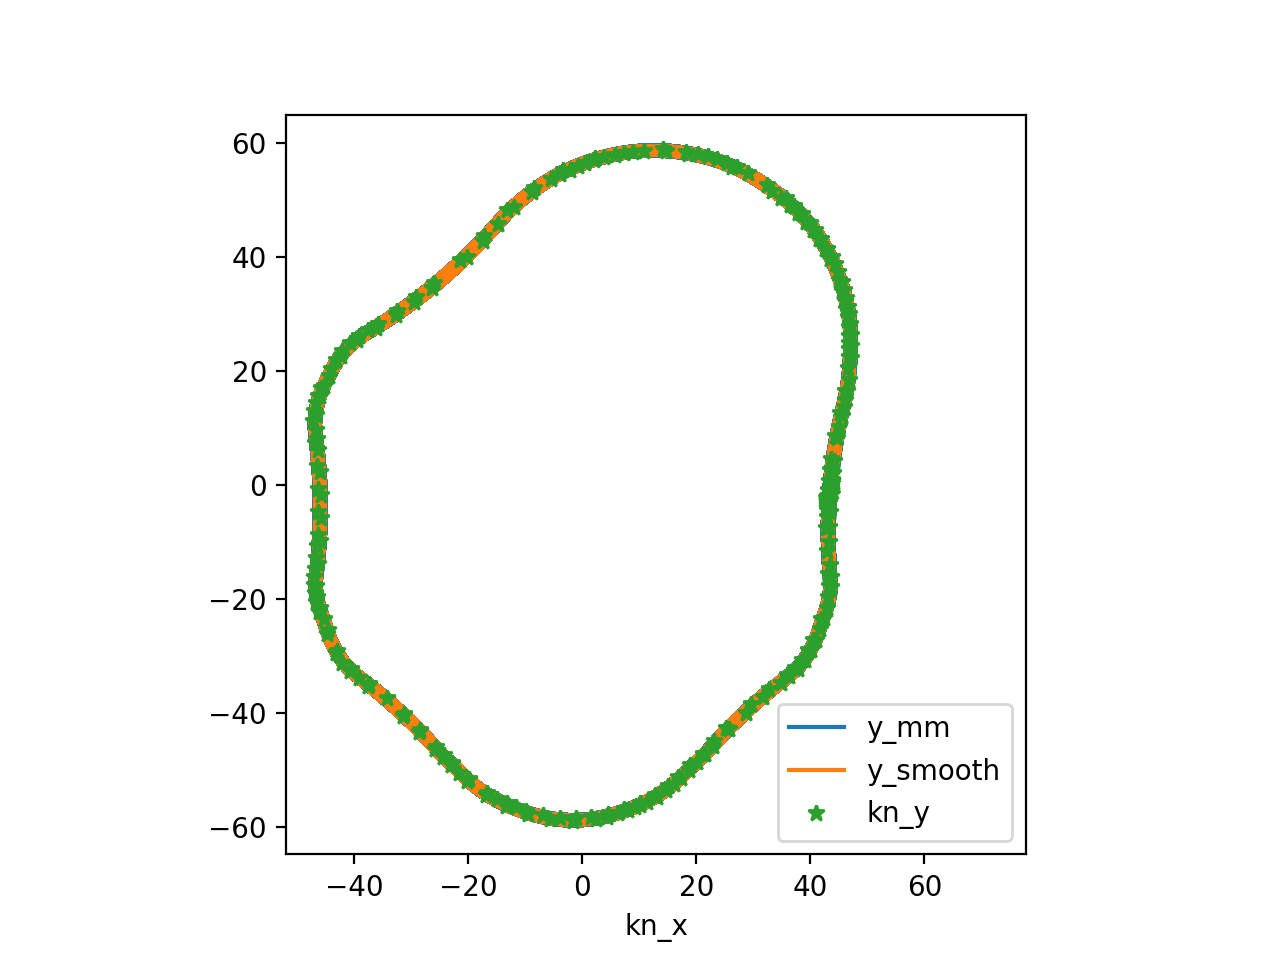

(-51.92627867530748, 77.76708985791058, -64.8508421867234, 64.84252634649467)

In [294]:
df_emu["x_mm"] = df_emu["apg0_x"]
df_emu["y_mm"] = df_emu["apg2_x"]
df_emu["e_mm"] = df_emu["apg4_x"]
df_emu["x_steps"] = df_emu["apg0_x"] * 80
df_emu["y_steps"] = df_emu["apg2_x"] * 80
df_emu["e_steps"] = df_emu["apg4_x"] * 837
df_emu["vx_mm"] = df_emu["apg0_v"]
df_emu["vy_mm"] = df_emu["apg2_v"]
df_emu["ve_mm"] = df_emu["apg4_v"]
last_t = df_emu["t"].iloc[-1]
orig_n = int(last_t * 1000)
print(orig_n)


knots = c.knots()[0]
res3 = c(knots)
df2 = pd.DataFrame()
df2["kn_x"] = res3[:, 0]
df2["kn_y"] = res3[:, 1]
df2["kn_e"] = res3[:, 2]
df2["t"] = c.knots()[0]
knots_n = np.searchsorted(knots, last_t)

#res4 = c(df_emu["t"] + knots[0])
#df_emu["c_x"] = res4[:, 0]
#df_emu["c_y"] = res4[:, 1]
#df_emu["c_e"] = res4[:, 2]

ax = df_emu.plot(x="x_mm", y="y_mm", style=".-", zorder=1)
#df_emu.plot(x="c_x", y="c_y", style=".-", zorder=2, ax=ax)
df[:orig_n].plot(x="x_smooth", y="y_smooth", style=".-", zorder=2, ax=ax)
df2[:knots_n].plot(x="kn_x", y="kn_y", style="*", ax=ax, zorder=3)
plt.axis("square")

<IPython.core.display.Javascript object>


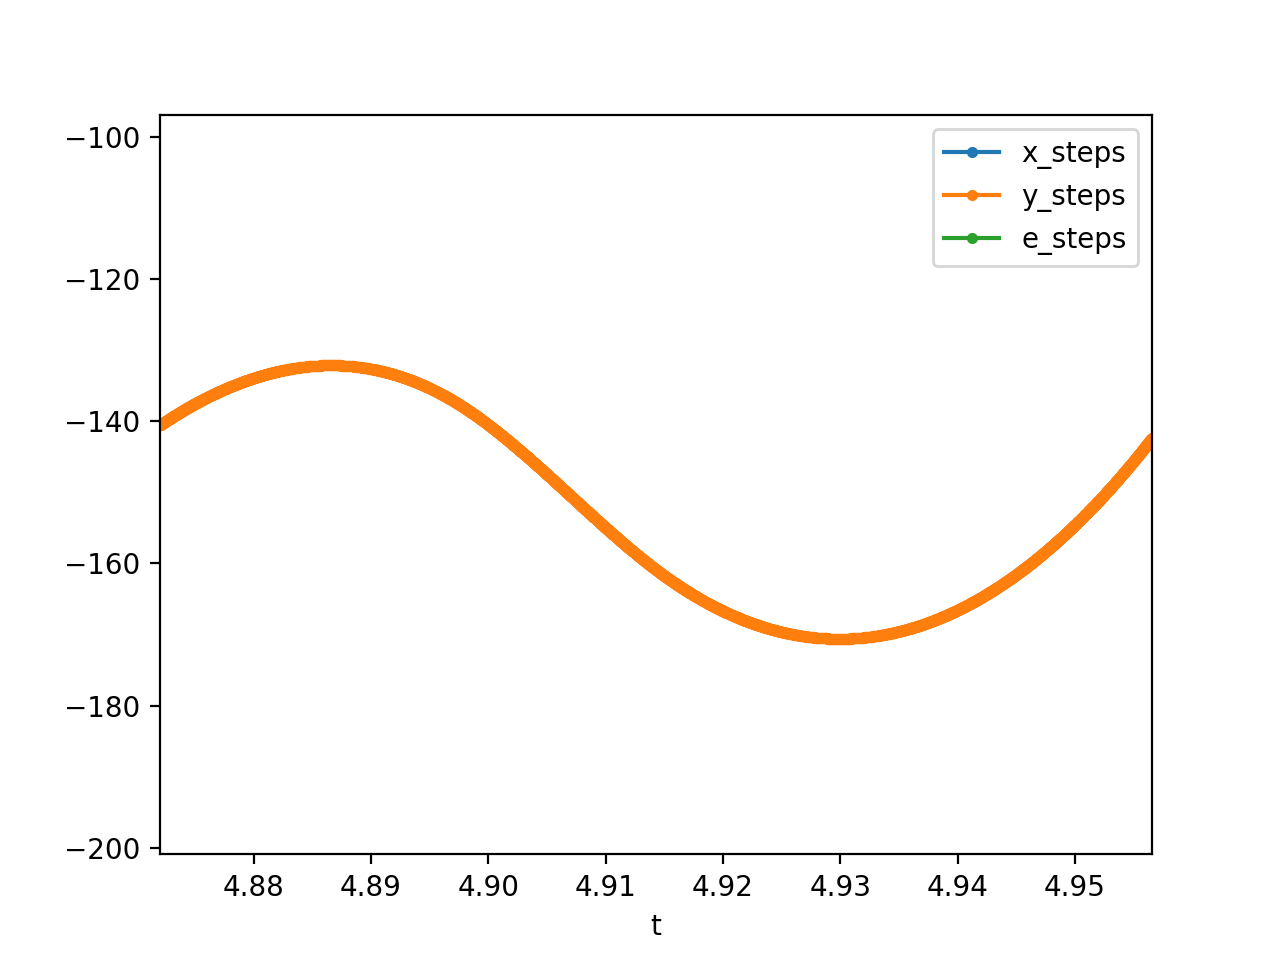

In [295]:
df_emu.plot(x="t", y=["x_steps", "y_steps", "e_steps"], style=".-", zorder=2)
